# Turbulent shock thickness estimation

In this notebook, we reproduce all the figures from the paper: Lacombe, F, Roy, S., Sinha, K., Karl, S., and Hickey, J.-P. "Characteristic Scales in Shock/Turbulence Interaction", AIAA Journal (under review). This notebook can be extended to compute additional cases.

The semi-empirical model for the local velocity in the shock reads:
\begin{equation}
\dfrac{\partial \widetilde{u}}{\partial x} = \dfrac{-\frac{\gamma +1}{2}(\widetilde{u} - \widetilde{u_u})(\widetilde{u}- \widetilde{u_d})}{\mathcal{C} \left[ \dfrac{1}{ M^2}-{\gamma} + \dfrac{\gamma(1-\Gamma) R_{11}}{\tilde{u}^2}\right]}
\label{eq:solution}
\end{equation}

where: $\mathcal{C}=\left(\frac{\nu_t}{Pr_t}+\frac{\nu}{Pr}\right)$. The equations are derived from the one-dimensional, Favre-averaged Navier-Stokes equations under a number of simplifying assumptions as noted in Lacombe et al. Using the upstream quantities (indicated with a subscript "u"), we can compute the average shock thickness as:
\begin{equation}
	\left<\delta_t \right> = \frac{\widetilde{u_d} - \widetilde{u_u}}{\left.\partial \widetilde{u}/\partial x\right|_{max}} = \dfrac{8\mathcal{C}\left[ \dfrac{1}{ M_u^2}-{\gamma} + \dfrac{\gamma(1-\Gamma) R_{11,u}}{\tilde{u}_u^2}\right]}{(\gamma +1)(\widetilde{u}_d - \widetilde{u_u})}
\label{eq:solutionSimple}
\end{equation}


In [1]:
#REQUIRED MODULES TO RUN THE CODE and modification to the figures
import scipy as sp
import scipy.integrate
import numpy as np
import math
import sys
import math
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from scipy import optimize
import pickle

# Create beautiful figures
from myFigs import set_size,set_square,set_stretch,set_almostsquare,set_rect,set_ystretch
width = 504
nice_fonts = {
# Use LaTex to write all text
"text.usetex": True,
"font.family": "sans-serif",
"font.serif": "FreeSans",
# Use 10pt font in plots, to match 10pt font in document
"axes.labelsize": 10,
"font.size": 9.5,
# Make the legend/label fonts a little smaller
"legend.fontsize": 9,
"xtick.labelsize": 9.5,
"ytick.labelsize": 9.5,
}

matplotlib.rcParams.update(nice_fonts)

##  1. Shock profile calculations



In [2]:
def ODEsimple(u,x,u_up,u_ds,M, rho, k,eps,R11,mu,Pr, Pr_t,gamma,G): 
     ctheta = 0.09
     C      = (ctheta*k**2/eps/(rho*Pr_t)+mu/(rho*Pr))        
     DENOM  = C*(1.0/(M**2) - gamma +gamma*(1-G)*R11/u_up**2)
     NUM    = -(gamma+1.)/2.*(u-u_up)*(u-u_ds)
     small  = 0.0000000000001  # a small value is necessary to initiate the ODE solver
     return NUM/DENOM-small

In [3]:
def shockThickness(u_up,u_ds,M, rho, k,eps,R11,mu,Pr, Pr_t,gamma,G):    
     ctheta=0.09   
     u_mi   = 0.5*(u_up+u_ds)
     C      = ((ctheta*k**2/eps)/(rho*Pr_t)+mu/(rho*Pr)) 
     DENOM  = C*(1.0/(M**2) - gamma +gamma*(1-G)*R11/u_up**2)  
     NUM    = (gamma+1.)/2.*(u_mi-u_up)*(u_mi-u_ds)   
     dudx   = NUM/DENOM   
     return abs((u_ds-u_up)/dudx)

### 1.1 Sample profile calculation
In order to generate a continuous profile within the shock, the Equation (7) in the paper must be integrated. For simplicity, we use the scipy ODE integration tool. The following code uses the numerical result from Larsson et al. (2013) to define the upstream states. Note many of these quantities are taken directly from the DNS results.

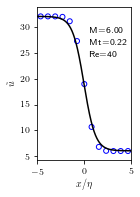

In [4]:
## CONSTANTS
gamma=1.4
Pr   = 0.72
Pr_t = 0.89

#DNScase= "m1.05_mt0.05_re40.pickle"
#DNScase= "m3.50_mt0.16_re75.pickle"
DNScase= "m6.00_mt0.22_re40.pickle"

####################################################
#DNS RESULTS FROM LARSSON et al. (2013)            #
# note: these values are from the DNS              #
####################################################


###################################
## Case M=1.05, M_t=0.05, Re=40
###################################
if DNScase== "m1.05_mt0.05_re40.pickle":  
  u_up  = 24.927150559377097
  M_up  = 1.0502023384431178
  Mt_up = 0.04917522424665162
  mu_up = 0.003571994856554456
  kolm  = 0.014116072115807328
  Re_L  = 342 #180.0
  figSave="figure1a.pdf"
  xmin=-15
  xmax=15
  M_text="M=1.05"
  Re_text="Re=40"
  Mt_text="Mt=0.05"
  posx= 2.
  posy= [24.85,24.65,24.45]


###################################
## Case M=3.5, M_t=0.16, Re=75
###################################
elif DNScase=="m3.50_mt0.16_re75.pickle":
    u_up = 19.39785386686046
    M_up = 3.4992396572274576
    Mt_up = 0.15531471200073468
    mu_up = 0.0003554750551811092
    kolm = 0.00263113577471059
    Re_L = 1273 #670.
    figSave="figure1b.pdf"
    xmin=-25
    xmax=25
    M_text="M=3.5"
    Re_text="Re=75"
    Mt_text="Mt=0.16"
    posx= 4.
    posy= [17.85,16.45,15.25]

###################################
## Case M=6.00, M_t=0.22, Re=40
###################################
elif DNScase=="m6.00_mt0.22_re40.pickle":
  Re_L  = 418 #220.0
  u_up  = 31.990917222063857
  M_up  = 6.005733139146068
  Mt_up = 0.23090186657944967
  mu_up = 0.003606628735999768
  kolm  = 0.014041953638982497
  figSave="figure1c.pdf"
  xmin=-5
  xmax=5
  M_text="M=6.00"
  Re_text="Re=40"
  Mt_text="Mt=0.22"
  posx= 0.5
  posy= [28.85,26.45,24.25]

rho_up=1.0
solut  = pickle.load( open( 'Larsson2013/'+DNScase, "rb" ) )

###################################
## set up numerical mesh
###################################
nb_grids=200000
x = np.linspace(-1, 10, nb_grids)
u = np.ones(nb_grids)*u_up

###################################
## Compute states from upstream
###################################
a_up   = u_up/M_up
urms   = Mt_up*a_up
rho_ds = (1.-(Mt_up**2/M_up**2))*((gamma+1.)*(M_up)**2/((gamma-1.)*(M_up)**2+2.))
denr   = rho_ds/rho_up
b1p    = 0.4*((denr-1.0)/5.0)**0.3
k_up   = ((Mt_up*a_up)**2)/2.
L_eps  = (Re_L*mu_up)/(rho_up*(2.*k_up/3.)**0.5)
eps_up = k_up**1.5/L_eps  
R11_up = (2./3.)*k_up        


## Compute the downstream state based on approximations
u_ds = u_up*rho_up/rho_ds
denr = rho_ds/rho_up
b1p = 0.4*((denr-1.0)/5.0)**0.3
G=-2.0+2.0*b1p+(4.0*0.55/3.0)

###################################
## integrate the numerical profile
###################################
u_prof = sp.integrate.odeint(ODEsimple, u_up, x,args=(u_up,u_ds,M_up, rho_up, k_up,eps_up,R11_up,mu_up,Pr, Pr_t,gamma,G))

offset=x.flat[np.abs(u_prof - 0.5*(u_ds+u_up)).argmin()] # compute the offset of the shock profile to set the midpoint to zero.
u_DNS=solut["u"]
x_DNS=solut["x"]
plt.figure(figsize=set_ystretch(0.3*width))
plt.plot((x-offset)/kolm,u_prof,'k')
plt.scatter(x_DNS[::150]/kolm,u_DNS[::150],marker='o', s=25, facecolors='none', edgecolors='b')
plt.xlim(xmin,xmax)
plt.xlabel(r'$x/\eta$')
plt.ylabel(r'$\tilde{u}$')
plt.text(0.5,28.85,M_text)
plt.text(0.5,26.45,Mt_text)
plt.text(0.5,24.25,Re_text)

plt.tight_layout()
plt.savefig(figSave)
plt.show()
   

# 2.0 Validation
The shock thickness model is assessed against the DNS simulations from Larsson et al. (2013) and Chen and Donzis (2019); in the latter case, only isotropic simulations are considered. The only values used are the upstream Reynolds (either $Re_\lambda$ or $Re_L$), Mach, and turbulent Mach numbers. The additional quantities are computed, assuming isotropic turbulence upstream of the shock. 

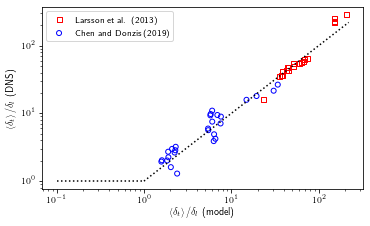

In [5]:
#################################################
# Data from: Chen and Donzis (2019): Table 1
#################################################
# M, Re_l, Mt, <delta_t>/dx,<delta_l>/dx, eta/dx
caseChen1 =[1.1,12,0.05,4.89,11.0,8.58]
caseChen2 =[1.1,10,0.08,4.84,9.4,4.86]
caseChen3 =[1.1,10,0.14,8.42,17.1,4.96]
caseChen4 =[1.1,11,0.22,6.9,13.9,2.55]
caseChen5 =[1.1,11,0.29,10.14,16.3,2.65]
caseChen6 =[1.1,11,0.34,13.31,17.2,2.82]
caseChen7 =[1.1,27,0.13,4.85,23.8,4.65]
caseChen8 =[1.1,24,0.22,4.57,25.8,2.56]
caseChen9 =[1.1,25,0.30,6.99,29.5,2.68]
caseChen10=[1.1,24,0.44,12.83,50,3.05]
caseChen11=[1.2,12,0.05,4.86,15.6,17.7]
caseChen12=[1.2,11,0.08,4.85,14.5,9.80]
caseChen13=[1.2,10,0.14,4.53,12.3,4.94]
caseChen14=[1.2,12,0.22,7.42,19.6,5.05]
caseChen15=[1.2,13,0.39,5.82,16.6,2.48]
caseChen16=[1.2,27,0.12,4.85,34.4,9.42]
caseChen17=[1.2,24,0.21,4.82,36.4,5.14]
caseChen18=[1.2,23,0.32,7.24,43.2,5.23]
caseChen19=[1.2,25,0.44,5.34,49.9,2.82]
caseChen20=[1.2,47,0.34,4.69,84.5,4.61]
caseChen21=[1.2,42,0.42,5.36,84.9,4.1]
caseChen22=[1.2,62,0.28,4.86,129,6.48]
caseChen23=[1.2,65,0.51,5.05,109,3.64]
caseChen24=[1.4,23,0.23,4.82,45.6,9.51]
caseChen25=[1.4,25,0.33,5.45,48.8,7.78]
caseChen26=[1.4,23,0.45,5.58,61.2,5.47]
caseChen27=[1.4,24,0.54,6.32,61.8,5.35]
casesChen=[caseChen1,caseChen2,caseChen3,caseChen4,caseChen5,caseChen6,caseChen7,caseChen8,caseChen9,caseChen10,caseChen11,caseChen12,caseChen13,caseChen14,caseChen15,caseChen16,caseChen17,caseChen18,caseChen19,caseChen20,caseChen21,caseChen22,caseChen23,caseChen24,caseChen25,caseChen26,caseChen27]

#################################################
# Data from: Larsson et al (2013): Table 1
#################################################
#Re_l,Re_L,M,Mt, delta_t/delta_l
JL1=[39,180,1.05,0.05,16.074]
JL2=[38, 180,1.28,0.15,35.043]
JL3=[39,190,1.28,0.22,35.686]
JL4=[38,180,1.28,0.26,36.497]
JL5=[38,180,1.28,0.31,41.919]
JL6=[38,180,1.5,0.15,42.918]
JL7=[39,190,1.5,0.22,42.850]
JL8=[39,190,1.51,0.31,48.18369]
JL9=[39,180,1.51,0.37,47.6197]
JL10=[39,190,1.87,0.22,49.229]
JL11=[39,190,1.87,0.31,53.5591]
JL12=[40,200,2.5,0.22,54.2509]
JL13=[40,200,3.5,0.16,56.089]
JL14=[41,210,3.5,0.23,58.1449]
JL15=[42,210,4.7,0.23,61.4302]
JL16=[42,220,6.0,0.23,64.621]
JL17=[73,650,1.50,0.14,226.216]
JL18=[73,660,1.5,0.22,220.2338]
JL19=[72,650,1.52,0.28,250.078]
JL20=[74,670,3.5,0.15,283.948]
casesJL=[JL1,JL2,JL3,JL4,JL5,JL6,JL7,JL8,JL9,JL10,JL11,JL12,JL13,JL14,JL15,JL16,JL17,JL18,JL19,JL20]

# Constants for the model
gamma  = 1.4
u_up   = 1.0
rho_up = 1.0
Pr     = 0.72
Pr_t   = 0.89
mu_up  = 0.001

# placeholder for results
deltaChen_l  = np.zeros(len(casesChen))
deltaChen_t  = np.zeros(len(casesChen))
DNS_Chen_comp= np.zeros(len(casesChen))
deltaJL_l    = np.zeros(len(casesJL))
deltaJL_t    = np.zeros(len(casesJL))
DNS_JL_comp  = np.zeros(len(casesJL))

# Model of Chen and Donzis (2019)
for ii,mycase in enumerate(casesChen):
    Re_L   = 1.0/10.*mycase[1]**2   #(Re_L and Re_lambda are both defined with u')
    M_up   = mycase[0]
    Mt_up  = mycase[2]
    a_up   = u_up/M_up
    urms   = Mt_up*a_up
    rho_ds = (1.-(Mt_up**2/M_up**2))*((gamma+1.)*(M_up)**2/((gamma-1.)*(M_up)**2+2.))
    u_ds   = u_up*rho_up/rho_ds
    M_ds   = ((((gamma-1.)*M_up**2+2)/(2.*gamma*M_up**2-(gamma-1)))**0.5)
    denr   = rho_ds/rho_up
    b1p    = 0.4*((denr-1.0)/5.0)**0.3
    k_up   = 3*((Mt_up*a_up)**2)/2.
    L_eps  = (Re_L*mu_up)/(rho_up*(2.*k_up/3.)**0.5)
    eps_up = k_up**1.5/L_eps
    R11_up = (2./3.)*k_up
    R11_ds = R11_up*denr**(2.-2.*b1p-(4.*0.55/3.))             

    tempr  = (M_up/(M_ds*denr))**2.0  
    
    G       =-2.0+2.0*b1p+(4.0*0.55/3.0)
    k1      = 4./3. +(gamma-1)/Pr
    
    deltaChen_l[ii] = 2*k1*mu_up/(rho_up*a_up*(M_up-M_ds))
    deltaChen_t[ii] = shockThickness(u_up,u_ds,M_up, rho_up, k_up,eps_up,R11_up,mu_up,Pr, Pr_t,gamma,G )   
    DNS_Chen_comp[ii]=mycase[4]/mycase[3]
    

# Model of Larsson et al (2013)
for ii,mycase in enumerate(casesJL):
    #Re_l,Re_L,M,Mt, delta_t/delta_l
    Re_L   = mycase[1] * 1.9 ################################################# Check here JP, 380 
    M_up   = mycase[2]
    Mt_up  = mycase[3]
    a_up   = u_up/M_up
    urms   = Mt_up*a_up
    rho_ds = (1.-(Mt_up**2/M_up**2))*((gamma+1.)*(M_up)**2/((gamma-1.)*(M_up)**2+2.))
    u_ds   = u_up*rho_up/rho_ds
    M_ds   = ((((gamma-1.)*M_up**2+2)/(2.*gamma*M_up**2-(gamma-1)))**0.5)
    denr   = rho_ds/rho_up
    b1p    = 0.4*((denr-1.0)/5.0)**0.3
    mu_up  = 0.0000001
    k_up   = ((Mt_up*a_up)**2)/2.
    L_eps  = (Re_L*mu_up)/(rho_up*(2.*k_up/3.)**0.5)
    eps_up = k_up**1.5/L_eps  
    R11_up = (2./3.)*k_up
    R11_ds = R11_up*denr**(2.-2.*b1p-(4.*0.55/3.))           

    tempr  = (M_up/(M_ds*denr))**2.0
  
    G             =-2.0+2.0*b1p+(4.0*0.55/3.0)
    k1            = 4./3. +(gamma-1)/Pr
    deltaJL_l[ii] = 2*k1*mu_up/(rho_up*a_up*(M_up-M_ds))
    deltaJL_t[ii] = shockThickness(u_up,u_ds,M_up, rho_up, k_up,eps_up,R11_up,mu_up,Pr, Pr_t,gamma,G) 
    DNS_JL_comp[ii]=mycase[4]


#Figure generation
plt.figure(figsize=set_size(0.75*width))    
plt.scatter(deltaJL_t/deltaJL_l,DNS_JL_comp,marker='s', s=25, facecolors='none', edgecolors='r',label="Larsson et al. (2013)")  
plt.scatter(deltaChen_t/deltaChen_l,DNS_Chen_comp,marker='o', s=25, facecolors='none', edgecolors='b',label="Chen and Donzis (2019)")  
plt.loglog([0.1,1],[1,1],'k:')      
plt.loglog([1,220],[1,220],'k:')    
plt.xlabel(r"$\left<\delta_t\right>/\delta_l$ (model)")
plt.ylabel(r"$\left<\delta_t\right>/\delta_l$ (DNS)")
plt.legend()
plt.tight_layout()
plt.savefig('figure2.pdf')
plt.show()




# 3.0 Effect of Mach number on shock thickness
Here we compare the functional relationship among the existing model by Ryu et al (2014) and Chen et al (2020).

/Users/j6hickey/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:101: RuntimeWarning: divide by zero encountered in true_divide
/Users/j6hickey/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:104: RuntimeWarning: divide by zero encountered in true_divide
/Users/j6hickey/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:118: RuntimeWarning: invalid value encountered in power
/Users/j6hickey/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:101: RuntimeWarning: divide by zero encountered in true_divide
/Users/j6hickey/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:104: RuntimeWarning: divide by zero encountered in true_divide
/Users/j6hickey/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:118: RuntimeWarning: invalid value encountered in power
/Users/j6hickey/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:101: RuntimeWarning: divide by zero encountered in true_divide
/Users

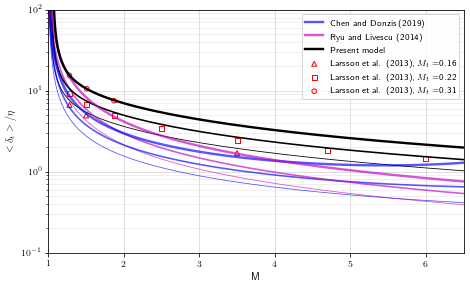

In [11]:
#%% Figure 3
plt.figure(figsize=set_size(0.95*width))    

# Constants
u_up = 1 ; nu_up = 1 ; Pr = 0.72 ; Pr_t = 0.89 ; gamma = 1.4 ; Re_L = 380

# For a nice display
Symbols = ['^','s','h']
Mt_list = [0.16,0.22,0.31]

# M, delta_t/delta_l
Mt016 = np.array([[1.28, 35.0430], \
                  [1.50, 42.9180], \
                  [3.50, 56.0890]])

Mt022 = np.array([[1.28, 35.6860], \
                  [1.50, 42.8500], \
                  [1.87, 49.2290], \
                  [2.50, 54.2509], \
                  [3.50, 58.1449], \
                  [4.70, 61.4302], \
                  [6.00, 64.621]])

Mt031 = np.array([[1.28, 41.9190], \
                  [1.51, 48.1837], \
                  [1.87, 53.5591]])
    
DNS = [Mt016, Mt022, Mt031]

# Loop on turbulent mach numbers
for (Symbol, Mt_up, data) in zip(Symbols, Mt_list, DNS):
    # Importing DNS results
    M_up = data[:,0]
    dtdl = data[:,1]
         
    # Estimating kolmogorov microscale           
    a_up   = u_up/M_up
    k_up   = ( (Mt_up*a_up)**2 )/2
    L_eps  = Re_L*nu_up / (2/3*k_up)**0.5
    eps_up = k_up**1.5/L_eps  
    kolm = (nu_up**3/eps_up)**0.25
    
    # Laminar thickness
    k1      = 4/3 + (gamma - 1)/Pr
    rho_ds  = (1 - (Mt_up**2/M_up**2) ) * ( (gamma + 1) * (M_up)**2 / ( (gamma-1) * (M_up)**2 + 2) )
    M_ds    = ( ( (gamma-1) * M_up**2 + 2) / ( 2*gamma*M_up**2 - (gamma - 1)) )**0.5
    delta_l = 2 * k1 * nu_up/( a_up * (M_up - M_ds) )    

    # Plotting results
    plt.scatter(M_up, dtdl*delta_l/kolm,marker=Symbol, s=25, facecolors='none', edgecolors='r',label=r'Larsson et al. (2013), $M_t =$'+str(Mt_up))  
    
# *****************
# Parametric study
# *****************
npts = 1000
M_up = np.geomspace(1.0,12,npts)

# Initializing tables
delta_PM   = np.zeros(npts)
delta_Ryu  = np.zeros(npts)
delta_Chen = np.zeros(npts)

# Correlation (Chen's model)
c1 = 0.042
c2 = 1.57

# Correlation (Ryu's model)
c_Ryu = 100

# Setting independant dimensionless variables
mu_up = 1 ; u_up = 1 ; rho_up = 1 ; nu_up = mu_up / rho_up

# For a magnificient plot
lineWidth = [0.8,1.6,2.4]
opacity = 0.66

# Loop on turbulent Mach numbers
for (LW, Mt_up) in zip(lineWidth, Mt_list):
    # Let's first compute the Kolmogorov microscale
    # up-stream speed of sound
    a_up   = u_up/M_up
    
    # upstream TKE
    k_up   = ((Mt_up*a_up)**2)/2
    
    # upstream dissipation rate
    L_eps  = (Re_L * mu_up)/(rho_up*(2*k_up/3)**0.5)    
    eps_up = k_up**1.5/L_eps
    
    # Kolmogorov microscale
    kolm  = ((mu_up/rho_up)**3/eps_up)**0.25
    
    # Re_lambda
    lamb = (10*nu_up * k_up / eps_up)**0.5
    Vrms = (2/3*k_up)**0.5
    Re_t = lamb * Vrms / nu_up
    
    # Laminar thickness
    k1 = 4/3 + (gamma -1) / Pr
    M_ds = ((((gamma-1)*M_up**2+2)/(2*gamma*M_up**2-(gamma-1)))**0.5)
    delta_l = 2*k1*mu_up/(rho_up*a_up*(M_up-M_ds))
    
    # Ryu's model
    delta_Ryu  = c_Ryu * kolm * Mt_up/(Re_t**0.5*( M_up - 1))

    # Chen's model
    delta_Chen = delta_l * (1 + c1 * Re_t**c2) / (1 - Mt_up**2/6 * (M_up**2 - 2*M_up - 1))

    # Present model
    # The turbulent shock thickness is computed from the upstream values of 
    # M, Mt and Re_L only
    # Downstream properties are deduced from the modified Rankine-Hugoniot relations
    rho_ds = (1-(Mt_up**2/M_up**2))*((gamma+1)*(M_up)**2/((gamma-1)*(M_up)**2+2))
    u_ds   = u_up*rho_up/rho_ds
    
    # Dimensionless variables
    denr   = rho_ds/rho_up
    b1p    = 0.4*((denr-1)/5)**0.3
    Pr_t   = 0.89
    R11_up = (2/3)*k_up
    G      = 2*b1p + (4*0.55/3) - 2

    # Computing shockthickness
    delta_t = shockThickness(u_up,u_ds,M_up, rho_up, k_up, eps_up, R11_up, mu_up, Pr, Pr_t,gamma,G) 
    
    # Plotting results
    if LW == lineWidth[-1]:    
        plt.semilogy(M_up,delta_Chen/kolm,'b',linewidth=LW,alpha=opacity,label='Chen and Donzis (2019)')
        plt.semilogy(M_up,delta_Ryu/kolm,'m',linewidth=LW,alpha=opacity,label='Ryu and Livescu (2014)')
        plt.semilogy(M_up,delta_t/kolm,'k',linewidth=LW, label='Present model')
    else:
        plt.semilogy(M_up,delta_Chen/kolm,'b',linewidth=LW,alpha=opacity)
        plt.semilogy(M_up,delta_Ryu/kolm,'m',linewidth=LW,alpha=opacity)
        plt.semilogy(M_up,delta_t/kolm,'k',linewidth=LW)

# Range of the graph        
plt.ylim(0.1,100)
plt.xlim(1,6.5)    
   
# Labels and legend 
plt.xlabel("M")
plt.ylabel(r"$<\delta_t>/\eta$")
plt.legend()
plt.tight_layout()

# Grid
plt.grid(which='major',alpha=0.5)
plt.grid(which='minor',alpha=0.25)

# Saving figure
plt.savefig('figure3.pdf')
plt.show()

## 4.0 Timescale shock 


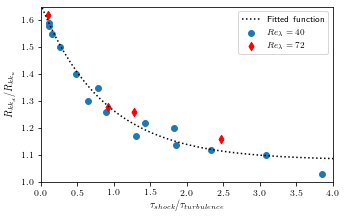

In [7]:
tscale,ampl=np.loadtxt("Larsson2013/timeScale.dat",unpack=True)
plt.figure(figsize=set_size(0.75*width))
plt.scatter(tscale[0:15],ampl[0:15],marker='o', s=35,label="$Re_\lambda=40$")
plt.scatter(tscale[15:19],ampl[15:19],marker='d', s=35,facecolors='r', edgecolors='r',label="$Re_\lambda=72$")
plt.xlabel(r"$\tau_{shock}/\tau_{turbulence}$")
plt.ylabel(r"$R_{{kk}_d}/R_{{kk}_u}$")


def test_func(x, a, b,c):
    return a * np.exp(b * x)+c

params, params_covariance = optimize.curve_fit(test_func, tscale, ampl,
                                               p0=[2, -1,2])
xdata=np.linspace(0,5)
plt.plot(xdata, test_func(xdata, params[0], params[1], params[2]),'k:',
         label='Fitted function')
plt.xlim(0,4)
plt.ylim(1,1.65)
plt.legend()
plt.savefig('figure4.pdf')
plt.show()